In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import random
import os
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier

path = '/content/drive/My Drive/Project'

In [ ]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [ ]:
def get_minidataset(data_size = 10000):
  train_features_temp = pd.read_csv(path+'/train_features.csv')
  train_targets_temp = pd.read_csv(path+'/train_targets_scored.csv')

  # full_data = pd.concat([train_features_temp, train_targets_temp], axis=1)

  # Creating the whole dataset by joining
  full_data = train_features_temp.join(train_targets_temp.set_index('sig_id'), on='sig_id')
  # print(full_data.head())
  # print(full_data.columns)

  sample_df = full_data.sample(n=data_size)
  train_features_temp = sample_df[ train_features_temp.columns]
  train_targets_temp = sample_df[train_targets_temp.columns]

  COLS = ['cp_type','cp_dose']
  FE = []
  for col in COLS:
      for mod in train_features_temp[col].unique():
          FE.append(mod)
          train_features_temp[mod] = (train_features_temp[col] == mod).astype(int)
  del train_features_temp['sig_id']
  del train_features_temp['cp_type']
  del train_features_temp['cp_dose']
  FE+=list(train_features_temp.columns) 
  del train_targets_temp['sig_id']

  scaler = MinMaxScaler()
  train_features_temp_rescaled = scaler.fit_transform(train_features_temp)

  return (train_features_temp_rescaled.copy(),train_targets_temp.copy())
  # comparison_column = np.where(full_data["col1"] == full_data["col2"], True, False)

# train_sample, test_sample = get_minidataset()
# print(train_sample)
# print(test_sample)

#Importing the data files into variables.

In [ ]:
train_features = pd.read_csv(path+'/train_features.csv')
train_targets = pd.read_csv(path+'/train_targets_scored.csv')
# get_minidataset()
# train_targets_nonscored = pd.read_csv('/kaggle/input/lish-moa/train_targets_nonscored.csv')
test_features = pd.read_csv(path+'/test_features.csv')
ss = pd.read_csv(path+'/sample_submission.csv')

#Preprocessing Steps
We will be doing preprocessing for the neural network. This is like one hot encoding. We convert the binary features into numrical ones.

In [ ]:
COLS = ['cp_type','cp_dose']
FE = []
print(train_features.head())
print("cols:", train_features['cp_type'].unique())
print("FE Before", FE)
for col in COLS:
    for mod in train_features[col].unique():
        FE.append(mod)
        train_features[mod] = (train_features[col] == mod).astype(int)
del train_features['sig_id']
del train_features['cp_type']
del train_features['cp_dose']
print("FE Mid", FE)
FE+=list(train_features.columns) 
del train_targets['sig_id']
print("FE After", FE)
print(train_features.head())
train_targets_copy = train_targets.copy()

for col in COLS:
    for mod in test_features[col].unique():
        test_features[mod] = (test_features[col] == mod).astype(int)
sig_id = pd.DataFrame()
sig_id = test_features.pop('sig_id')
del test_features['cp_type']
del test_features['cp_dose']

         sig_id cp_type  cp_time cp_dose  ...    c-96    c-97    c-98    c-99
0  id_000644bb2  trt_cp       24      D1  ... -0.3981  0.2139  0.3801  0.4176
1  id_000779bfc  trt_cp       72      D1  ...  0.1522  0.1241  0.6077  0.7371
2  id_000a6266a  trt_cp       48      D1  ... -0.6417 -0.2187 -1.4080  0.6931
3  id_0015fd391  trt_cp       48      D1  ... -1.6210 -0.8784 -0.3876 -0.8154
4  id_001626bd3  trt_cp       72      D2  ...  0.1094  0.2885 -0.3786  0.7125

[5 rows x 876 columns]
cols: ['trt_cp' 'ctl_vehicle']
FE Before []
FE Mid ['trt_cp', 'ctl_vehicle', 'D1', 'D2']
FE After ['trt_cp', 'ctl_vehicle', 'D1', 'D2', 'cp_time', 'g-0', 'g-1', 'g-2', 'g-3', 'g-4', 'g-5', 'g-6', 'g-7', 'g-8', 'g-9', 'g-10', 'g-11', 'g-12', 'g-13', 'g-14', 'g-15', 'g-16', 'g-17', 'g-18', 'g-19', 'g-20', 'g-21', 'g-22', 'g-23', 'g-24', 'g-25', 'g-26', 'g-27', 'g-28', 'g-29', 'g-30', 'g-31', 'g-32', 'g-33', 'g-34', 'g-35', 'g-36', 'g-37', 'g-38', 'g-39', 'g-40', 'g-41', 'g-42', 'g-43', 'g-44', 'g-45', 'g-

In [ ]:
train_features.describe(percentiles = [.25,.5,.75,.95,.97])

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,...,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,trt_cp,ctl_vehicle,D1,D2
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,0.119905,-0.123321,0.182307,0.143203,0.209402,-0.173884,-0.024432,0.126823,-0.146663,0.087687,-0.082982,-0.111908,-0.087379,0.047548,-0.117474,-0.113212,-0.052746,-0.091055,0.112176,-0.046458,-0.076239,-0.197699,0.382177,-0.189432,0.078791,-0.093312,0.135729,-0.188616,-0.606710,0.534425,...,-0.402083,-0.619682,-0.452265,-0.497164,-0.413836,-0.277029,-0.547845,-0.358611,-0.442906,-0.475194,-0.010404,-0.467001,-0.276963,-0.455848,-0.412918,-0.456404,-0.472514,-0.505481,-0.492735,-0.446836,-0.463029,-0.409310,-0.333124,-0.295009,-0.328342,-0.401615,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505,0.921643,0.078357,0.510078,0.489922
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,1.087180,1.291501,1.253604,1.234590,1.273068,1.247178,0.659839,1.418997,1.179688,0.743301,0.844796,1.219529,0.824401,0.924838,0.760159,1.203186,0.866977,1.103765,1.001687,1.027758,1.279399,1.302567,1.559174,0.933514,1.172270,1.174325,1.061719,1.397677,2.200277,2.003317,...,1.785055,2.225596,1.991021,2.063896,1.887001,1.459639,2.187835,1.730634,1.924716,2.021927,1.029820,2.004317,1.429340,1.924263,1.888788,1.832863,2.011396,2.091353,2.055624,1.987476,2.014045,1.883974,1.647241,1.634073,1.663170,1.832794,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918,0.268739,0.268739,0.499909,0.499909
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,-8.337000,-10.000000,-5.870000,-8.587000,-5.018000,-10.000000,-10.000000,-10.000000,-10.000000,-4.226000,-10.000000,-10.000000,-5.700000,-10.000000,-10.000000,-10.000000,-8.272000,-8.184000,-4.835000,-7.913000,-10.000000,-10.000000,-2.956000,-8.356000,-7.182000,-10.000000,-9.261000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-9.839000,-10.000000,-10.000000,-10.000000,-10.000000,-6.452000,-10.000000,-9.938000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,-0.360200,-0.511475,-0.489675,-0.447500,-0.481200,-0.607975,-0.404150

#Principal Component Analysis - PCA

In [ ]:
print(train_features.var())

cp_time        376.468917
g-0              1.941560
g-1              0.659934
g-2              1.072739
g-3              0.902523
                  ...    
c-99             1.982232
trt_cp           0.072220
ctl_vehicle      0.072220
D1               0.249909
D2               0.249909
Length: 877, dtype: float64


In [ ]:
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(train_features)

# Add code for rescaling test set also here!
data_rescaled_test = scaler.fit_transform(test_features)

print(data_rescaled)
print(data_rescaled_test)
# data_rescaled_df = pd.DataFrame(data_rescaled)
# print(data_rescaled_df.var())

[[0.         0.42383807 0.58414068 ... 0.         1.         0.        ]
 [1.         0.36016889 0.57031366 ... 0.         1.         0.        ]
 [0.5        0.39586154 0.58636785 ... 0.         1.         0.        ]
 ...
 [0.5        0.3807903  0.56724202 ... 1.         0.         1.        ]
 [0.         0.39831109 0.55395323 ... 0.         1.         0.        ]
 [1.         0.29995488 0.62741277 ... 0.         1.         0.        ]]
[[0.         0.31167678 0.49234847 ... 0.         1.         0.        ]
 [1.         0.33536323 0.50403319 ... 0.         1.         0.        ]
 [0.         0.35938907 0.46112007 ... 1.         1.         0.        ]
 ...
 [1.         0.32129104 0.45939156 ... 0.         1.         0.        ]
 [0.5        0.27576529 0.2727587  ... 0.         0.         1.        ]
 [1.         0.31353045 0.51132749 ... 0.         1.         0.        ]]


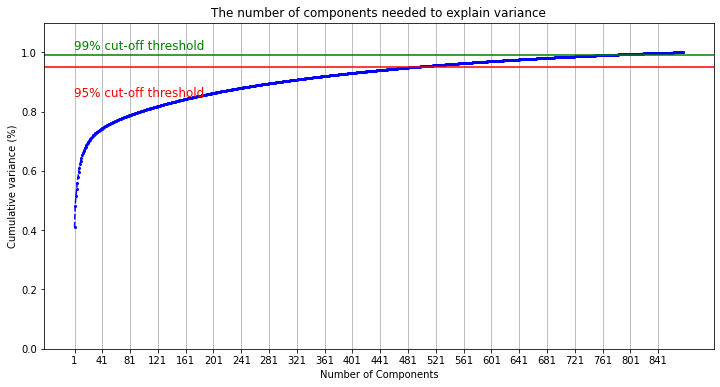

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit(data_rescaled)

% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 878, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
# print(pca.explained_variance_ratio_)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b',markersize=2)

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 881, step=40)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)

plt.axhline(y=0.99, color='g', linestyle='-')
plt.text(0.5, 1.01, '99% cut-off threshold', color = 'green', fontsize=12)

ax.grid(axis='x')
plt.show()

In [ ]:
pca = PCA(n_components = 0.97)
pca.fit(data_rescaled)
reduced_train = pca.transform(data_rescaled)
reduced_test =  pca.transform(data_rescaled_test)

reduced_train_df = pd.DataFrame(reduced_train)
reduced_test_df = pd.DataFrame(reduced_test)

print(reduced_train_df)
print(reduced_test_df)

            0         1         2    ...       599       600       601
0     -0.729049 -0.701666  0.176362  ...  0.005022  0.001329  0.033726
1     -0.660716 -0.707870 -0.360534  ...  0.025756 -0.040021  0.014898
2     -0.188032 -0.709365 -0.094825  ... -0.007536  0.011077 -0.009908
3      1.112766 -0.715944  0.196309  ...  0.028200 -0.023158 -0.006163
4     -0.674272  0.703319 -0.205600  ...  0.017542  0.037771  0.002354
...         ...       ...       ...  ...       ...       ...       ...
23809 -0.627295  0.704321  0.077921  ...  0.059653  0.027039 -0.015623
23810 -0.442825  0.724776  0.200438  ...  0.001480 -0.000830  0.002390
23811 -0.775880  0.710183 -0.000462  ... -0.009782  0.051527  0.050435
23812 -0.103661 -0.717138  1.546007  ... -0.006437 -0.066009  0.002523
23813  1.498553 -0.653233 -0.817547  ... -0.036559 -0.020435 -0.071869

[23814 rows x 602 columns]
           0         1         2    ...       599       600       601
0    -0.792289 -0.729838 -0.352811  ... -0.006456 

#GRID SEARCH
We will be using the to tune the hyperparameters of the neural network model

In [ ]:
# # Model for PCA 0.95
# def make_model(optimizer='Adamax', init_mode = 'uniform', activation = 'softmax' , neurons = 2445, dropout_rate=0.2):
#   model = tf.keras.Sequential([
#     tf.keras.layers.Input(489),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(units=neurons, kernel_initializer=init_mode, activation=activation),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(dropout_rate),
#     tf.keras.layers.Dense(units=neurons, kernel_initializer=init_mode, activation=activation),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(dropout_rate),
#     tf.keras.layers.Dense(206,kernel_initializer=init_mode, activation="sigmoid")
#     ])

#   model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["accuracy"])
#   return model

# Model for .97 PCA
def make_model(optimizer='Nadam', init_mode = 'uniform', activation = 'softmax' , neurons = 2445, dropout_rate=0.25):
    model = tf.keras.Sequential([
    tf.keras.layers.Input(602),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=neurons, kernel_initializer=init_mode, activation=activation),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons, kernel_initializer=init_mode, activation=activation),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(206,kernel_initializer=init_mode, activation='softmax')
    ])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["accuracy", "AUC"])
    return model

# Model for non-PCA
# def make_model(optimizer='Adamax', init_mode = 'uniform', activation = 'softmax'):
#   model = tf.keras.Sequential([
#     tf.keras.layers.Input(877),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(4096,kernel_initializer=init_mode, activation=activation),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(4096,kernel_initializer=init_mode, activation=activation),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(206,kernel_initializer=init_mode, activation="sigmoid")
#     ])

#   model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["accuracy"])
#   return model

# model().fit(reduced_train_df, epochs=10, batch_size=128)

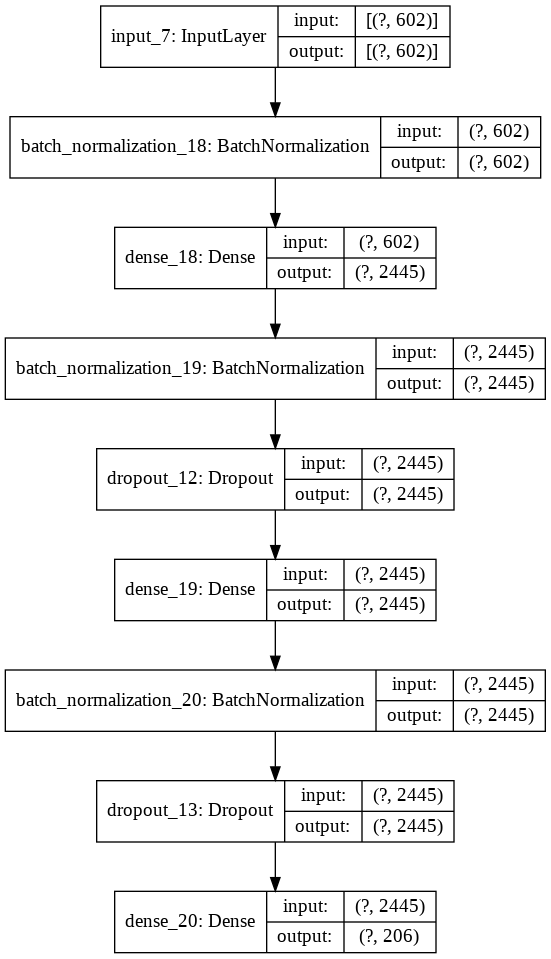

In [ ]:
tf.keras.utils.plot_model(make_model(),show_shapes=True)

#RESULTS
Best Optimizer - Adamax <br>
Best initialization - Uniform

In [ ]:
# optimizer = ['RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['Nadam']
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# activation = ['softmax']
# init_mode = ['uniform']
# neurons = [1467, 1956, 2445, 2934]
# neurons = [2408, 3010, 3612]
neurons = [3612]
# dropout_rate = [0.15, 0.2, 0.25, 0.3]
dropout_rate = [0.25]
param_grid = dict(optimizer=optimizer, init_mode=init_mode, activation=activation, neurons=neurons, dropout_rate=dropout_rate)

X, Y = get_minidataset(7000)
# print(X)
# print(Y.values)
# model().fit(X, Y, epochs=20, batch_size=128)

pca_sample = PCA(n_components = 0.97)
pca_sample.fit(X)
X = pca.transform(X)

model = KerasClassifier(build_fn= make_model, epochs=100, batch_size=150)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X,Y.values)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/100
47/47 [==============================] - 1s 23ms/step - loss: 0.0280 - accuracy: 0.0900 - auc: 0.6403
Epoch 2/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0129 - accuracy: 0.3549 - auc: 0.8960
Epoch 3/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0094 - accuracy: 0.4424 - auc: 0.9417
Epoch 4/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0078 - accuracy: 0.4934 - auc: 0.9572
Epoch 5/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0068 - accuracy: 0.5257 - auc: 0.9667
Epoch 6/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0063 - accuracy: 0.5454 - auc: 0.9686
Epoch 7/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0059 - accuracy: 0.5573 - auc: 0.9736
Epoch 8/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0058 - accuracy: 0.5643 - auc: 0.9734
Epoch 9/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0057 - accur

In [ ]:
NFOLD = 5
kf = KFold(n_splits=NFOLD)

BATCH_SIZE=32
EPOCHS=50
# print(test_features)

pe = np.zeros((reduced_test_df.shape[0], 206))

# train_features = train_features.values
train_features = reduced_train
test_features = reduced_test
train_targets = train_targets.values
pred = np.zeros((reduced_train_df.shape[0], 206))

cnt=0

history = None

for tr_idx, val_idx in kf.split(train_features):
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, epsilon=1e-4, mode='min')
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(optimizer='adam')
    history = net.fit(train_features[tr_idx], train_targets[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS,validation_data=(train_features[val_idx], train_targets[val_idx]), callbacks=[reduce_lr_loss], verbose=0)
    print("train", net.evaluate(train_features[tr_idx], train_targets[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(train_features[val_idx], train_targets[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(train_features[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(test_features, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.

Epoch 00043: 

In [ ]:
if history:
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

NameError: ignored

In [ ]:
pe.shape

columns = pd.read_csv(path+'/train_targets_scored.csv')
del columns['sig_id']
sub = pd.DataFrame(data=pe, columns=columns.columns)

In [ ]:
sample = pd.read_csv(path+'/sample_submission.csv')
sub.insert(0, column = 'sig_id', value=sample['sig_id'])

In [ ]:
sub.to_csv('submission.csv', index=False)
sub

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000049,0.000179,0.000409,0.038095,0.002558,0.007057,0.000209,0.000116,0.000026,0.000147,0.004550,0.000365,0.000005,0.000077,0.000040,0.000511,0.000730,0.001541,0.000554,0.000132,0.000551,0.000084,0.000022,0.004001,0.000127,0.000100,0.000169,0.000143,0.000583,0.000049,0.000480,0.002295,0.003744,0.000015,0.000005,0.000012,0.000015,0.000019,0.000045,...,0.000539,0.000016,0.000641,0.000004,0.000026,0.011938,0.000537,0.000226,0.001995,0.003519,0.000731,0.000154,0.000111,0.001007,0.000051,0.000022,0.153693,0.001124,0.000009,0.000087,0.001405,0.001208,0.003502,0.001012,0.004780,0.000668,0.000737,0.000348,0.007666,0.000152,0.000152,0.000017,0.000550,0.001261,0.000002,0.000122,6.107888e-07,0.000141,0.000888,0.000780
1,id_001897cda,0.001680,0.001128,0.002645,0.000107,0.000120,0.000346,0.002776,0.059542,0.011127,0.000962,0.000047,0.002335,0.000890,0.002882,0.000976,0.001587,0.008191,0.007454,0.002669,0.001372,0.013545,0.011858,0.000193,0.002686,0.000672,0.006169,0.000255,0.007980,0.000344,0.000457,0.004725,0.031754,0.002884,0.000552,0.000019,0.000211,0.000516,0.006886,0.000214,...,0.000206,0.000969,0.000128,0.000375,0.001569,0.002994,0.000732,0.050811,0.006165,0.000951,0.000878,0.000460,0.000063,0.000194,0.000519,0.000916,0.003116,0.001201,0.000997,0.000328,0.007938,0.001000,0.002862,0.000370,0.003358,0.001504,0.000801,0.013314,0.001046,0.001877,0.001066,0.001309,0.000661,0.000038,0.000305,0.000944,7.918842e-04,0.001135,0.001232,0.000912
2,id_002429b5b,0.001108,0.000796,0.001694,0.008156,0.010456,0.002254,0.003619,0.011242,0.000511,0.003901,0.010008,0.000478,0.000085,0.006310,0.000785,0.001514,0.001463,0.005212,0.005704,0.001008,0.004534,0.003025,0.000140,0.004455,0.000198,0.003462,0.000584,0.001013,0.007412,0.001173,0.001296,0.022839,0.005335,0.000174,0.000026,0.000079,0.001842,0.001397,0.000202,...,0.001926,0.000403,0.002521,0.000073,0.001391,0.002459,0.000886,0.003939,0.003285,0.003498,0.017590,0.002253,0.000645,0.001994,0.000392,0.000812,0.003861,0.002508,0.000578,0.000132,0.012642,0.002195,0.003774,0.000859,0.002445,0.002493,0.000325,0.001863,0.003347,0.002146,0.000233,0.000487,0.002244,0.195690,0.000117,0.000234,4.697288e-05,0.000564,0.005360,0.0015

In [ ]:
def metric(y_true, y_pred):
    metrics = []
    for _target in y_true.columns:
        metrics.append(log_loss(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float), labels=[0,1]))
    return np.mean(metrics)
print(metric(pd.DataFrame(train_targets),pd.DataFrame(pred)))

0.017533377474340757
